In [1]:
import sys
!"{sys.executable}" -m pip install scipy ipywidgets
import scipy_material


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /home/flaurent/Boxes/tumbleweed-1/Projects/misc/scientific_python/.venv/bin/python -m pip install --upgrade pip


<h1 align='center'>Statistical tests with the SciPy library</h1>

<div style='text-align:center'><img src='https://docs.scipy.org/doc/scipy/_static/logo.svg' /></div>

[SciPy](https://docs.scipy.org/doc/scipy/reference/#api-definition) is a collection of mathematical tools aiming at diverse fields, with functionalities split in several modules:

In [2]:
from scipy import (
        cluster,     # Clustering algorithms
        constants,   # Physical and mathematical constants
        fftpack,     # Fast Fourier Transform routines
        integrate,   # Integration and ordinary differential equation solvers
        interpolate, # Interpolation and smoothing splines
        io,          # Input and Output
        linalg,      # Linear algebra
        ndimage,     # N-dimensional image processing
        odr,         # Orthogonal distance regression
        optimize,    # Optimization and root-finding routines
        signal,      # Signal processing
        sparse,      # Sparse matrices and associated routines
        spatial,     # Spatial data structures and algorithms
        special,     # Special functions
        stats,       # Statistical distributions and functions
        )

`scipy.stats` content (see the [official documention](https://docs.scipy.org/doc/scipy/reference/reference/stats.html#module-scipy.stats)):

* [Probability distributions](https://docs.scipy.org/doc/scipy/reference/reference/stats.html#probability-distributions)
* [Summary statistics](https://docs.scipy.org/doc/scipy/reference/reference/stats.html#summary-statistics)
* [Frequency statistics](https://docs.scipy.org/doc/scipy/reference/reference/stats.html#frequency-statistics)
* [Correlation functions](https://docs.scipy.org/doc/scipy/reference/reference/stats.html#correlation-functions)
* [Statistical tests](https://docs.scipy.org/doc/scipy/reference/reference/stats.html#statistical-tests)
* ...

`scipy.stats` features basic functionalities and we will occasionally mention the `statsmodels` and `pingouin` libraries as we will hit `scipy.stats` limitations.

# Outline

We will merely review statistical tests:

* Distributions
* Student $t$ tests
    * compare a sample mean against the population mean
    * compare means of two independent samples
    * compare the means of paired samples
* Analyses of variance (one-way)
    * compare more than two group means
* Tests for other tests' assumptions
    * normality tests
    * homoscedasticity tests
* $\chi^2$ tests for categorical variables
    * goodness-of-fit tests
    * homogeneity and independence tests
* Correlation coefficient and linear regression
* Effect sizes

# Distributions

For this section, the related utilities are provided by `scipy.stats`:

In [3]:
import numpy as np
import pandas as pd
from scipy import stats

Reminder about module loading:

Example: how to access the `sem` function defined in the `scipy.stats` module?

In [4]:
%%script echo skipping

import scipy.stats
scipy.stats.sem

from scipy import stats
stats.sem

from scipy.stats import *
sem

skipping


## Confidence intervals

Common information such as the sample mean or standard deviation are trivial to obtain. For example, we have seen Pandas' `describe`:

In [5]:
dataframe = pd.read_csv('../data/happiness.csv')
dataframe.describe()
#dataframe.describe(exclude=np.number)

,year,score,gdp,family,health,freedom,generosity
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,2016.983146,5.384433,0.927765,1.084706,0.618347,0.410976,0.212137
std,1.421058,1.127515,0.398686,0.330334,0.241488,0.152395,0.115306
min,2015.000000,2.693000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016.000000,4.511250,0.631888,0.877478,0.466158,0.310890,0.127045
50%,2017.000000,5.328000,0.990357,1.128175,0.652632,0.430770,0.199319
75%,2018.000000,6.227000,1.230653,1.341106,0.805084,0.531000,0.273473
max,2019.000000,7.769000,2.096000,1.644000,1.141000,0.724000,0.611705


To report the value of the population mean and account for the uncertainty that results from the fact the true value is actually unknown (the sample mean above is our best guess), we can give a confidence interval instead.

Reminder: the population mean follows a normal distribution centered at the sample mean, with standard deviation equal to the standard error of the mean (or, equivalently, the standard deviation of the sample divided by the square root of the sample size).

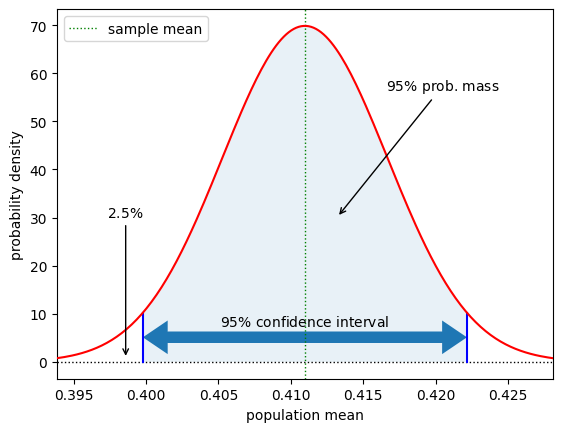

In [6]:
scipy_material.illustration_confidence_interval(0.410976, stats.sem(dataframe['freedom']))

Computing a confidence interval with SciPy involves instantiating the normal distribution with the `norm` function and calling the `interval` method of the returned object.

In [7]:
X = dataframe['freedom']
mu = np.mean(X)
sigma = stats.sem(X)
distribution_of_the_mean = stats.norm(mu, sigma)

In [8]:
distribution_of_the_mean.interval(0.95)

(np.float64(0.39978235603755674), np.float64(0.4221699825735007))

Note again that we have set the scale parameter `sigma` equal to the sem. In contrast, if variable `Proteines` followed a normal distribution, we could define its distribution as:

In [9]:
normal_distribution = stats.norm(X.mean(), X.std())

The objects `norm` returns (*e.g.* `distribution_of_the_mean`) feature numerous other methods:

In [10]:
# probability density function
distribution_of_the_mean.pdf(0.4)

np.float64(11.018949544165157)

In [11]:
# cumulative distribution function
distribution_of_the_mean.cdf(0.4)

np.float64(0.02731194353841207)

See [scipy.stats.rv_continuous](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.html#scipy.stats.rv_continuous) for more methods.

As another example, we can make use of the inverse survival function `isf` to re-implement the calculation of the $1-\alpha=95\%$ confidence interval based on the following formula:

$$
\bar{x} \pm z_{1-\alpha/2}\frac{\sigma}{\sqrt{n}}
$$

Indeed, $z_{1-\alpha/2}$ is calculated as follows:

In [12]:
alpha = 0.05
z = stats.norm().isf(alpha / 2)
z

np.float64(1.9599639845400545)

For a $95\%$ confidence interval, we usually take $z\approx 1.96$. Note we took the standard normal distribution, with null mean and unit standard deviation (`stats.norm()` is equivalent to `stats.norm(0, 1)`).

$\frac{\sigma}{\sqrt{n}}$ is the standard deviation of the sample mean, or standard error of mean, that we have already calculated using the `sem` function.

In [13]:
print(f'Freedom to make life choice is {mu:.3f}±{z * sigma:.3f} on average')

Freedom to make life choice is 0.411±0.011 on average


## Fitting

We have seen how to fit a normal distribution explicitly passing a mean and standard deviation. More generally, for any distribution from `scipy.stats`, we can get the required parameters using the `stats.<distribution>.fit` method. For example, for distribution `stats.norm` with sample `X`:

In [14]:
normal_distribution = stats.norm(*stats.norm.fit(X))

Now, unlike the population mean, there is no guarantee a sample follows a normal distribution.

To determine what distribution a sample best follows, we can fit various distributions to the data and visually appreciate how well these distributions match with the data by plotting a scaled histogram and the probability density functions of the fitted distributions on top of the histogram.

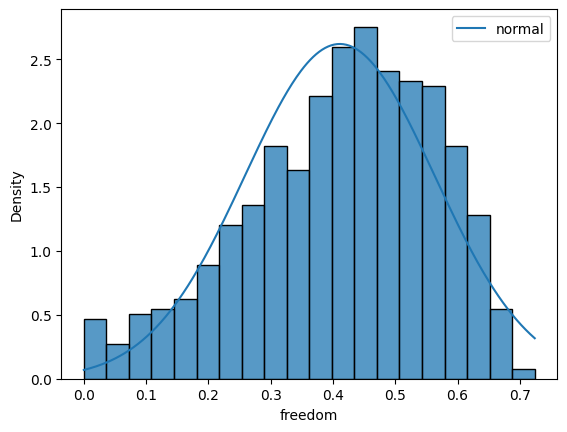

In [15]:
# plot the histogram
import seaborn as sns
ax = sns.histplot(X, bins=20, stat='density')
curve_names = []

# fit a normal distribution
norm = stats.norm(*stats.norm.fit(X))

# draw the probability density function
from matplotlib import pyplot as plt
grid = np.linspace(X.min(), X.max(), 300)
ax.plot(grid, norm.pdf(grid))
curve_names.append('normal')

# fit and overlay more distributions
t = stats.t(*stats.t.fit(X))
chi2 = stats.chi2(*stats.chi2.fit(X))
if False:
    ax.plot(grid, t.pdf(grid))
    curve_names.append('t')
    ax.plot(grid, chi2.pdf(grid))
    curve_names.append('chi2')

weibull_min = stats.weibull_min(*stats.weibull_min.fit(X))
weibull_max = stats.weibull_max(*stats.weibull_max.fit(X))
if False:
    ax.plot(grid, weibull_min.pdf(grid))
    curve_names.append('weibull minimum extreme value')
    ax.plot(grid, weibull_max.pdf(grid))
    curve_names.append('weibull maximum extreme value')

if curve_names:
    ax.legend(curve_names)

Note that plotting histograms is good practice anyway, because it helps to spot data distributions with multiple modes. Multiple modes in a sample are a red flag for tests that compare estimates of central tendency (*e.g.* means).

...and we can test whether `Freedom to make life choice` follows a Weibull distribution in our sample with the one-sample Kolmogorov-Smirnov test:

In [16]:
statistic, pvalue = stats.kstest(X, weibull_max.cdf)
pvalue

np.float64(0.7512133915520728)

# Statistical testing


> What did we do?

We compared our **observations** `x` with some **expectation**.

We actually formulated a so-called *null hypothesis*, denoted $H_0$, that models the situation such that "nothing is going on", *i.e.* the observations meet the expectation.

We also implicitly defined an alternative hypothesis, usually denoted $H_1$ or $H_A$, that can simply be the opposite of $H_0$.

For example:

$$
\left\{
\begin{array}{ l l l }
H_0: & X \sim \mathcal{N}(\mu, \sigma^2) & \mbox{with } \mu \mbox{ assumed to be } \bar{x} \mbox{ and } \sigma^2 \mbox{ as } \frac{1}{n-1}\sum_{i=0}^{n-1} (x_i - \bar{x})^2 \\
H_A: & \mbox{not } H_0
\end{array}
\right.
$$

A test consists in contrasting the two incompatible hypotheses.

If we had a single observation – say $z=1.4$ – to compare with a distribution – say $\mathcal{N}(0,1)$ – we would simply compute the probability for this value to be drawn from this distribution (or not):

In [17]:
z = 1.4

N = stats.norm(0, 1)

onesided_pvalue = N.sf(z) # sf= survival function
twosided_pvalue = 2 * min(N.cdf(z), N.sf(z))

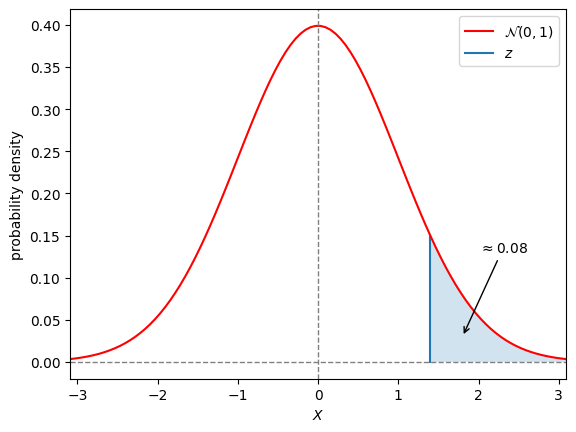

In [18]:
scipy_material.illustration_onesided_probabilitymass(z, N, onesided_pvalue)

In practice, all tests boil down to comparing a single value with a reference distribution. Basically, a test expresses the discrepancy between the observations and the expectation in the shape of a *statistic*, and this statistic is supposed to follow a given distribution under $H_0$.

This is used as a basis to calculate a *p*-value that estimates the probability of erroneously rejecting $H_0$.

The experimenter also defines a significance level $\alpha$, with common values $\alpha=0.05$ or $0.01$, that sets the maximum tolerated risk of making a *type-1 error*, *i.e.* of rejecting $H_0$ by chance.
If the obtained <em>p</em>-value is lower than $\alpha$, then s·he can conclude there is sufficient evidence to reject $H_0$.

In [19]:
%%html
<style>table#typeoferrors { text-align: center; font-size: large; margin-left: 1px;} #typeoferrors td { text-align: center; font-size: large; border-right: solid 1px black; border-bottom: solid 1px black; } #typeoferrors td.border { font-size: small; border-left: solid 1px black; border-top: solid 1px black; } #typeoferrors td.wrong { color: orange; } #typeoferrors td.ok { color: green; } #typeoferrors span.sub { font-size: x-small; } #typeoferrors td.footnote { text-align: left; font-size: xx-small; border-right: 0px; border-bottom: 0px; } </style> <table id="typeoferrors">     <tr><td rowspan="2" colspan="2"></td><td colspan="2" class="border">Conclusion about $H_0$<br />from the statistical test</td></tr>    <tr><td>accept</td><td>reject</td></tr>     <tr><td rowspan="2" class="border">Truth about $H_0$<br />in the population</td><td>true</td><td class="ok">Correct</td><td  class="wrong">Type 1 error<br /><span class="sub">observe difference<br />when none exists</span></td></tr>     <tr><td>false</td><td class="wrong">Type 2 error<br /><span class="sub">fail to observe difference<br />when one exists</span></td><td class="ok">Correct</td></tr>     <tr><td colspan="4" class="footnote"> <a href="https://faculty.nps.edu/rbassett/_book/hypothesis-testing-one-sample.html#fig:errorsHypTesting">https://faculty.nps.edu/rbassett/_book/hypothesis-testing-one-sample.html#fig:errorsHypTesting</a>     </td></tr> </table>

## *t* tests

*t* tests derive a statistic that is supposed to follow the [Student's *t* distribution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html) under $H_0$:

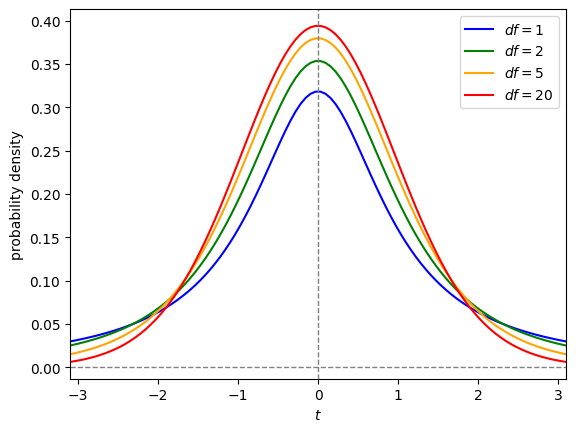

In [20]:
scipy_material.illustration_t_pdfs()

At high degrees of freedom, the *t* distribution approaches the normal distribution. At lower degrees of freedom, the *t* distribution exhibits heavier tails and is less sensitive to extreme values.

### One-sample *t* test

This test compares a sample's central tendency (*sample mean*) with a reference value (*population mean*).

<table style="text-align: center;"><tr><td>
<img src='../images/8mice.svg' />
</td><td>
<img src='../images/Scientific_journal_icon.svg' width="96px" />
</td></tr><tr><td><center>
<code>x=[49.5 81.9 64.0 17.3 59.8 94.6 69.9 12.4]</code>
</center></td><td><center>
<code>&mu;=50</code>
</center></td></tr></table>

Let us call $\mu$ this reference value. Our expectation is that the sample mean $\bar{X}$ is close enough to $\mu$.
In other words, $H_0: \bar{X} = \mu$.
The statistic is:
$$
\frac{\bar{X} - \mu}{\mathrm{SEM}} \mbox{ } \mbox{ } \mbox{ } \mbox{ } \mbox{ } \mbox{ } \mbox{ } \sim t(n-1) \mbox{ } \textrm{under} \mbox{ } H_0
$$


`scipy`'s one-sample *t* test is [ttest_1samp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_1samp.html):

`scipy.stats.ttest_1samp(a, popmean, axis=0, nan_policy='propagate', alternative='two-sided')`

In [21]:
mu = 50

x = np.array([49.47257879, 81.93967205, 64.030398, 17.25423608, 59.80082512,
              94.56012514, 69.91672899, 12.39640637])

stats.ttest_1samp(x, mu)

TtestResult(statistic=np.float64(0.6024056396957578), pvalue=np.float64(0.5658990587680466), df=np.int64(7))

If we do not mind a negative difference (resp. positive difference), *i.e.* we consider the danger zone to begin only above (resp. below) the expected value, we can make the test one-sided to gain statistical power.
To this aim, we must choose and specify which side passing the `alternative` argument with value `'greater'` (resp. `'less'`):

In [22]:
stats.ttest_1samp(x, mu, alternative='greater')

TtestResult(statistic=np.float64(0.6024056396957578), pvalue=np.float64(0.2829495293840233), df=np.int64(7))

Note: the returned object can be expanded (or unpacked) like a `(statistic, pvalue)` tuple, there its values can be retrieved in various ways:

In [23]:
statistic, pvalue = stats.ttest_1samp(x, mu) # without `df`
(statistic, pvalue)

(np.float64(0.6024056396957578), np.float64(0.5658990587680466))

In [24]:
result = stats.ttest_1samp(x, mu)
(result.statistic, result.pvalue, result.df)

(np.float64(0.6024056396957578), np.float64(0.5658990587680466), np.int64(7))

### *t* test for independent samples

This test compares the means of two samples or groups, *e.g.* a control sample and a sample from a mutated population: $H_0: \bar{X_1} = \bar{X_2}$.

<table style="text-align:center;"><tr><td>
<img src="../images/8mice.svg" alt="sample of the control population" />
</td><td>
<img src="../images/8mutants1.svg" alt="sample of a mutated population" />
</td></tr><tr><td><center>
<code>x<sub>1</sub>=[49.5 81.9 64.0 17.3 59.8 94.6 69.9 12.4]</code>
</center></td><td><center>
<code>x<sub>2</sub>=[64.2 96.6 101.9 85.3 66.5 63.9 127.6 55.0]</code>
</center></td></tr></table>

`scipy`'s *t* test for independent samples uses the statistic $t=\frac{\bar{X_1}-\bar{X_2}}{\sqrt{(\frac{1}{n_1}+\frac{1}{n_2})\mbox{ }\textrm{PooledVariance}}}$ with $\textrm{PooledVariance} = \frac{1}{n_1+n_2-2}\sum_{j\in\{1,2\}}\sum_i (x_{ij}-\bar{x_j})^2$ and is available as [ttest_ind](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html):

`scipy.stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate', permutations=None, random_state=None, alternative='two-sided', trim=0)`

In [25]:
x1 = x
x2 = np.array([64.22723692, 96.56483856, 101.94191774, 85.31918879,
               66.49529990, 63.88841224, 127.63861749, 55.00527005])

stats.ttest_ind(x1, x2)

TtestResult(statistic=np.float64(-1.96174329619957), pvalue=np.float64(0.06998888828308221), df=np.float64(14.0))

`scipy`'s implementation does not require equal numbers of observations per group, but assumes the groups have [similar variances ($0.5<\frac{s_{X_1}}{s_{X_2}}<2$)](https://en.wikipedia.org/wiki/Student%27s_t-test) (section “Equal or unequal sample sizes, similar variances (1/2 < sX1/sX2 < 2)”).
For heterogeneous groups, `ttest_ind` also implements Welch's *t* test with `equal_var=False`.

### *t* test for paired samples

<img src='../images/paired1.svg' />

`scipy`'s *t* test for paired samples is [ttest_rel](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html):

`scipy.stats.ttest_rel(a, b, axis=0, nan_policy='propagate', alternative='two-sided')`

This is actually a one-sample *t* test of the between-group differences against a population mean equal to zero (compare [1](https://github.com/scipy/scipy/blob/v1.7.1/scipy/stats/stats.py#L6450-L6460) and [2](https://github.com/scipy/scipy/blob/v1.7.1/scipy/stats/stats.py#L5647-L5656)).

### Effect sizes

Very low *p*-values are not measurements of the strength of an effect. One should consider the *effect size* instead.

A common measure of effect size for two independent samples is [Cohen's $d$](https://en.wikipedia.org/wiki/Effect_size#Cohen's_d): $d = \frac{\bar{X_2}-\bar{X_1}}{\sqrt{\textrm{PooledVariance}}}$

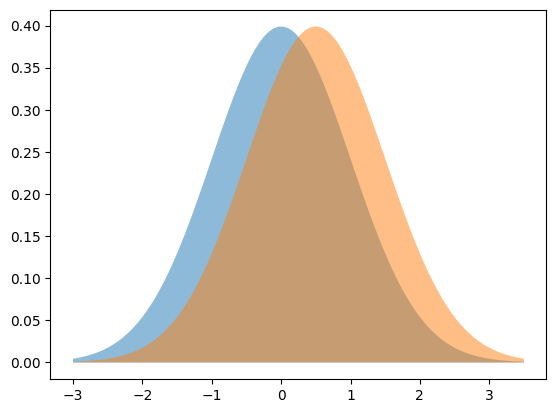

interactive(children=(FloatSlider(value=0.5, description='cohen_d', max=4.0), Output()), _dom_classes=('widget…

In [26]:
scipy_material.illustration_cohen_d();

With large enough sample sizes, one can find significant effects of size $0.1$ for example, which may not be of practical interest. Statistical significance does not imply practical significance.
   
Measurements of effect size were proposed together with tables for interpreting size values. For example, for Cohen's $d$:
   
| $|d|$ | size of effect |
| :-: | :-- |
| $0.2$ | small |
| $0.5$ | medium |
| $0.8$ | large |

In [27]:
def cohen_d(x1, x2):
    n1, n2 = len(x1), len(x2)
    m1, m2 = np.mean(x1), np.mean(x2)
    v1, v2 = np.var(x1), np.var(x2)
    pooled_variance = (n1 * v1 + n2 * v2) / (n1 + n2 - 2)
    d = (m2 - m1) / np.sqrt(pooled_variance)
    return d

Adjusted Cohen's $d$ for dependent samples:

In [28]:
r, _ = stats.pearsonr(x1, x2)
cohen_d(x1, x2) / np.sqrt(1 - r)

np.float64(1.1839903712840414)

## Analysis of variance

### One-way ANOVA

Comparing three or more group means reads $H_0: \bar{X_0} = \bar{X_1} = ... = \bar{X_k}$ and is usually carried out with an *analysis of variance*.

The total variance ($SS_{\textrm{total}}$) is decomposed as the sum of two terms: *within-group* variance ($SS_{\textrm{error}}$) and *between-group* variance ($SS_{\textrm{treatment}}$).

$$
\underbrace{\sum_j\sum_i (x_{ij} - \bar{\bar{x}})^2}_{SS_{\textrm{total}}} = \underbrace{\sum_j\sum_i (\bar{x_j} - \bar{\bar{x}})^2}_{SS_{\textrm{treatment}}} + \underbrace{\sum_j\sum_i (x_{ij} - \bar{x_j})^2}_{SS_{\textrm{error}}}
$$
Many statistical tools give the following detailled table:

| Source | Degrees of<br />freedom | Sum of squares | Mean squares | $\mbox{ }F\mbox{ }$ | $p$-value |
| :- | :-: | :-: | :-: | :-: | :-: |
| Treatment | $k-1$ | $SS_{\textrm{treatment}}$ | $MS_{\textrm{treatment}}$ | $\frac{MS_{\textrm{treatment}}}{MS_{\textrm{error}}}$ | $\mbox{ }p\mbox{ }$ |
| Error | $N-k$ | $SS_{\textrm{error}}$ | $MS_{\textrm{error}}$ | | |
| Total | $N-1$ | $SS_{\textrm{total}}$ | | | |

The statistic $F = \frac{MS_{\textrm{treatment}}}{MS_{\textrm{error}}}$ follows the Fisher's [F](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f.html) distribution under $H_0$.

More about it at: https://www.coursera.org/learn/stanford-statistics/lecture/pskeN/the-idea-of-analysis-of-variance

The most basic [implementation](https://github.com/scipy/scipy/blob/v1.7.1/scipy/stats/mstats_basic.py#L2937-L2967) of the one-way ANOVA in SciPy is [f_oneway](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.stats.f_oneway.html):

In [29]:
A = [85, 86, 88, 75, 78, 94, 98, 79, 71, 80]
B = [91, 92, 93, 85, 87, 84, 82, 88, 95, 96]
C = [79, 78, 88, 94, 92, 85, 83, 85, 82, 81]

stats.f_oneway(A, B, C)

F_onewayResult(statistic=np.float64(2.357532255133564), pvalue=np.float64(0.11384795345837218))

The ANOVA is an *omnibus* test and does not tell which groups exhibit differing means. Specific differences are later identified using *post-hoc tests* (more about it in next session).

Again, the values in the returned object can be retrieved in various ways:

In [30]:
statistic, pvalue = stats.f_oneway(A, B, C)
(statistic, pvalue)

(np.float64(2.357532255133564), np.float64(0.11384795345837218))

In [31]:
result = stats.f_oneway(A, B, C)
(result.statistic, result.pvalue)

(np.float64(2.357532255133564), np.float64(0.11384795345837218))

### Assumptions

The standard ANOVA requires the data to exhibit the following properties:

* independent observations,
* normally distributed residuals,
* all groups have equal population variance (*homoscedasticity*),
* at least 5 observations ($n \ge 5$) per group (and equal number).

#### Size effect

Mentioned for completeness: Cohen's $f=\sqrt{\frac{R^2}{1 - R^2}}=\sqrt{\frac{SS_{\textrm{treatment}}}{SS_{\textrm{error}}}}$ and [$\sqrt{F}$ root mean square effect](https://en.wikipedia.org/wiki/Effect_size#%CE%A8,_root-mean-square_standardized_effect) are suitable for one-way ANOVA but not widely used, as post-hoc tests give a more natural approach to size effects.

`statsmodels` features [effectsize_oneway](https://www.statsmodels.org/stable/generated/statsmodels.stats.oneway.effectsize_oneway.html).

## Checking for common assumptions

Visually checking for desired properties like normality or equal variance is acceptable, especially if the data are generally known to exhibit these properties.

### Normality

Having this property is usually not critical, because most tests are fairly robust to non-normality.
We only need to avoid cases of «extreme non-normality».

Beware however that, in the case of residuals (prediction errors of a model), a departure from normality may be an indication of systematic errors in some groups.

#### Graphical approaches

Probability plots with [probplot](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html) (or [statsmodels.api.qqplot](https://www.statsmodels.org/stable/generated/statsmodels.graphics.gofplots.qqplot.html) with one sample):

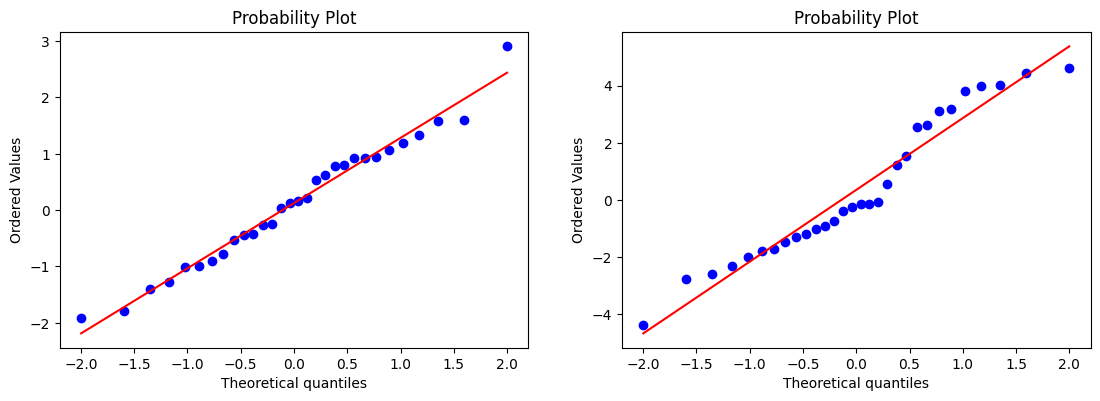

In [32]:
np.random.seed(1245619531)

x_normal = stats.norm.rvs(loc=0, scale=1, size=30) # generate 30 observations from the standard normal distribution
x_not_normal = stats.norm.rvs(loc=[-1,1], scale=[1,3], size=(15,2)).ravel() # generate 30 observations from a mixture of normal distributions

_, axes = plt.subplots(1, 2, figsize=(13.3,4.1))

stats.probplot(x_normal, plot=axes[0])
stats.probplot(x_not_normal, plot=axes[1]);

#### Normality tests

* D'Agostino's test: [normaltest](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.stats.normaltest.html), preferably for large samples ($n>20$),
    * Similar test for skewness only: [skewtest](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.stats.skewtest.html) ($n\ge8$),

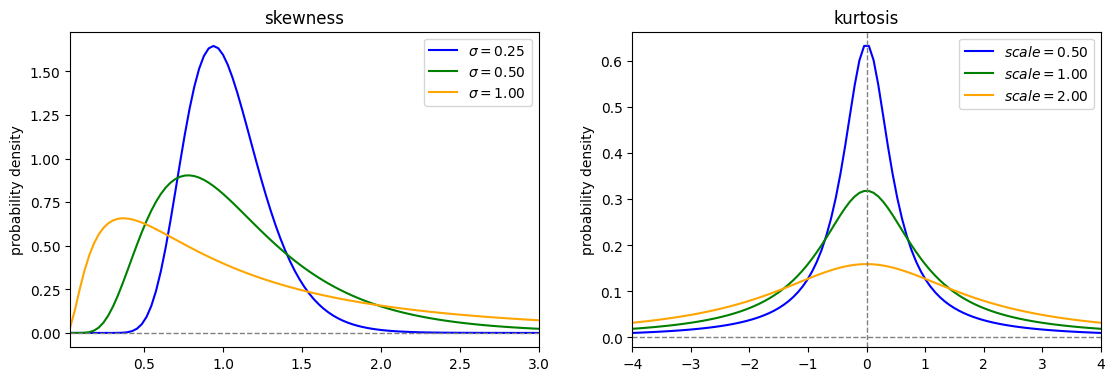

In [33]:
skewed_dist = lambda sigma, x: np.exp( -.5*(np.log(x)/sigma)**2 ) / ( x*sigma*np.sqrt(2*np.pi) )
heavy_tailed_dist = lambda scale, x: stats.cauchy.pdf(x, 0, scale)

colors = ['blue', 'green', 'orange', 'red']
_, axes = plt.subplots(1, 2, figsize=(13.3,4.1))

grid = np.linspace(0, 3, 100)
grid = grid[1:]

ax = axes[0]
for sigma, color in zip((.25, .5, 1), colors):
    ax.plot(grid, skewed_dist(sigma, grid), '-', color=color, label=f'$\\sigma={sigma:.2f}$')
    
ax.axhline(0, linestyle='--', color='grey', linewidth=1)
ax.set_xlim(grid[[0,-1]])
ax.set_title('skewness')

grid = np.linspace(-4, 4, 100)

ax = axes[1]
for s, color in zip((.5, 1, 2), colors):
    ax.plot(grid, heavy_tailed_dist(s, grid), '-', color=color, label=f'$scale={s:.2f}$')
    
ax.axvline(0, linestyle='--', color='grey', linewidth=1)
ax.axhline(0, linestyle='--', color='grey', linewidth=1)
ax.set_xlim(grid[[0,-1]])
ax.set_title('kurtosis')

for ax in axes:
    ax.set_ylabel('probability density')
    ax.legend();

* Shapiro-Wilk's test: [shapiro](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.stats.shapiro.html),
* Generic goodness-of-fit tests: [kstest](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.stats.kstest.html) and [anderson](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.stats.anderson.html).

### Equal variance (homoscedasticity)

#### Graphical approaches

Simple per-group box plots.

/tmp/ipykernel_6158/663227822.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df, labels=df.columns);


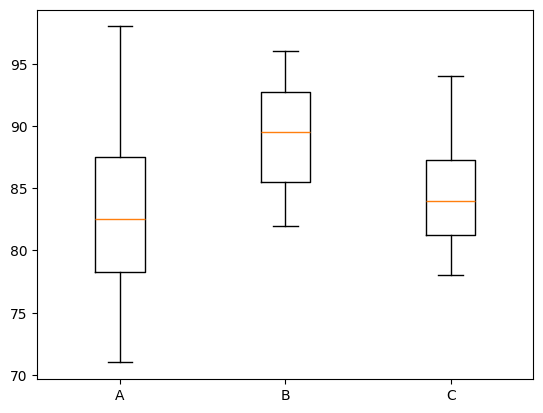

In [34]:
A = [85, 86, 88, 75, 78, 94, 98, 79, 71, 80]
B = [91, 92, 93, 85, 87, 84, 82, 88, 95, 96]
C = [79, 78, 88, 94, 92, 85, 83, 85, 82, 81]

df = pd.DataFrame(data=dict(A=A, B=B, C=C))
plt.boxplot(df, labels=df.columns);

#### Equality-of-variance tests

* Bartlett's test: [bartlett](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bartlett.html), most basic and common test,
* Levene's test: [levene](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html), better for skewed or heavy-tailed distributions,
* ...and others: Fligner-Killeen's test ([fligner](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fligner.html)), Ansari-Bradley's test ([ansari](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ansari.html)), etc

Example:

In [35]:
# copied-pasted from https://www.statology.org/bartletts-test-python/
A = [85, 86, 88, 75, 78, 94, 98, 79, 71, 80]
B = [91, 92, 93, 85, 87, 84, 82, 88, 95, 96]
C = [79, 78, 88, 94, 92, 85, 83, 85, 82, 81]

stats.bartlett(A, B, C)

BartlettResult(statistic=np.float64(4.855399204876762), pvalue=np.float64(0.08823958541402636))

In the above example, as there is not enough evidence to reject $H_0$ ($p>0.05$), we can proceed to perform a standard one-way ANOVA. Otherwise, we would go for an Alexander-Govern's test or Welch's *F* test instead.

The Alexander-Govern's test is available in `scipy` as [alexandergovern](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.stats.alexandergovern.html), but the Welch's *F* test is not (neither in `scipy.stats` nor in `statsmodels`). Install the `Pingouin` package and try out the [welch_anova](https://pingouin-stats.org/generated/pingouin.welch_anova.html) function instead.

The Bartlett's test statistic follows $\chi^2_{k-1}$ with $k$ the number of groups. As most tests based on the $\chi^2$ distribution, the *p*-value is one-sided.

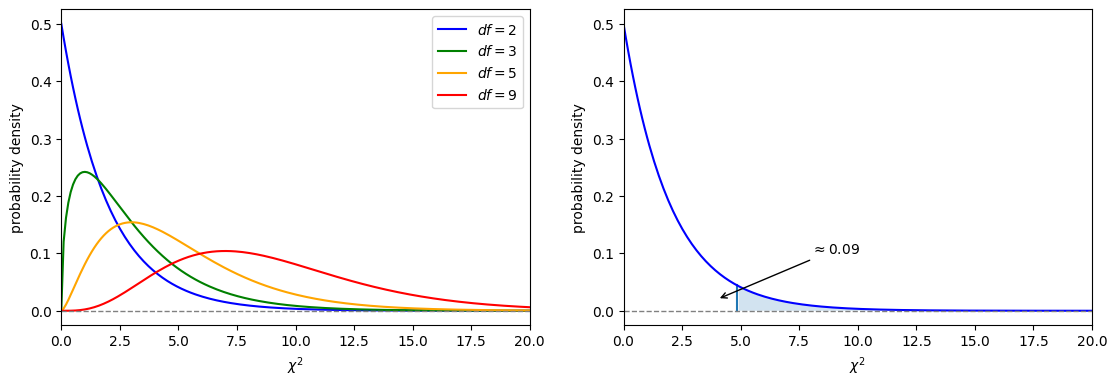

In [36]:
grid = np.linspace(0, 20, 200)

dfs = [2, 3, 5, 9]

_, axes = plt.subplots(1, 2, figsize=(13.3,4.1))

ax = axes[0]
for df, color in zip(
    dfs,
    ['blue', 'green', 'orange', 'red'],
):
    chi2 = stats.chi2.pdf(grid, df)
    ax.plot(grid, chi2, '-', color=color)
    
ax.axhline(0, linestyle='--', color='grey', linewidth=1)
ax.set_xlim(grid[0],grid[-1])
ax.set_xlabel(r'$\chi^2$')
ax.set_ylabel('probability density')
ax.legend([ f'$df={df}$' for df in dfs ])

ax = axes[1]
df, color = 2, 'blue'
chi2 = stats.chi2.pdf(grid, df)
ax.plot(grid, chi2, '-', color=color)
ax.axhline(0, linestyle='--', color='grey', linewidth=1)
ax.set_xlim(grid[0],grid[-1])
ax.set_xlabel(r'$\chi^2$')
ax.set_ylabel('probability density');

A = [85, 86, 88, 75, 78, 94, 98, 79, 71, 80]
B = [91, 92, 93, 85, 87, 84, 82, 88, 95, 96]
C = [79, 78, 88, 94, 92, 85, 83, 85, 82, 81]
bartlett_statistic, bartlett_pvalue = stats.bartlett(A, B, C)
bartlett_statistic_line, = ax.plot([bartlett_statistic]*2, [0, stats.chi2.pdf(bartlett_statistic, df)], '-', zorder=1)

tail = grid[bartlett_statistic<=grid]
ax.fill_between(tail, np.zeros_like(tail), stats.chi2.pdf(tail, df), alpha=.2)

ax.annotate(f'$\\approx {bartlett_pvalue:.2f}$', (4, .02), xytext=(8, .1), arrowprops=dict(arrowstyle="->"));

## χ² tests

When the sum of the observations is known, *e.g.* observations are frequencies -- proportions that sum to $1$, we use a $\chi^2$ test instead of an ANOVA.

### Goodness-of-fit

Example:
Comparing the frequencies of the different allele variants at a given locus between a reference genome and a test genome.

Another popular example: [Color proportion of M&Ms [Coursera]](https://www.coursera.org/learn/stanford-statistics/lecture/rAwbR/the-color-proportions-of-m-ms):

| blue | orange | green | yellow | red | brown |
| :-:  | :-:    | :-:   | :-:    | :-: | :-:   |
| 24%  | 20%    | 16%   | 14%    | 13% | 13%   |

In [37]:
expected_props  = np.array([ .24, .2, .16, .14, .13, .13 ])
observed_counts = np.array([ 85, 79, 56, 64, 58, 68 ])
np.sum(observed_counts)

np.int64(410)

In [38]:
expected_counts = expected_props * np.sum(observed_counts)
expected_counts

array([98.4, 82. , 65.6, 57.4, 53.3, 53.3])

|          | blue | orange | green | yellow | red  | brown |
| --:      | :-:  | :-:    | :-:   | :-:    | :-:  | :-:   |
| Expected | 98.4 | 82     | 65.6  | 57.4   | 53.3 | 53.3  |
| Observed | 85   | 79     | 56    | 64     | 58   | 58    |

The statistic is:

$$
\chi^2 = \sum_{i=1}^{k} \frac{(O_i - E_i)^2}{E_i} \mbox{ } \mbox{ } \mbox{ } \mbox{ } \mbox{ } \mbox{ } \mbox{ } \sim \chi^2_{k-1} \mbox{ } \textrm{under} \mbox{ } H_0
$$

In [39]:
k = len(expected_counts)
chi2 = np.sum((observed_counts - expected_counts) ** 2 / expected_counts)
chi2

np.float64(8.566983829178941)

In [40]:
pvalue = stats.chi2(k-1).sf(chi2)
pvalue

np.float64(0.1276329790529603)

`scipy.stats`'s implementation of the test is [chisquare](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html):

In [41]:
stats.chisquare(observed_counts, expected_counts)

Power_divergenceResult(statistic=np.float64(8.566983829178941), pvalue=np.float64(0.1276329790529603))

Again, there are various ways of getting the statistic and *p*-value:

In [42]:
statistic, pvalue = stats.chisquare(observed_counts, expected_counts)
(statistic, pvalue)

(np.float64(8.566983829178941), np.float64(0.1276329790529603))

In [43]:
result = stats.chisquare(observed_counts, expected_counts)
(result.statistic, result.pvalue)

(np.float64(8.566983829178941), np.float64(0.1276329790529603))

#### Size effect

Cohen's $w$:

In [44]:
cohen_w = np.sqrt(chi2)
cohen_w

np.float64(2.9269410361636843)

### Homogeneity and independence

Example:
Comparing the frequency of cell types in cultures that differ in the treatments:

| Observed    | Type A cells | Type B cells | Type C cells | Type D cells |
| --:         | :-:          | :-:          | :-:          | :-:          |
| Treatment 1 | 134          | 86           | 32           | 11           |
| Treatment 2 | 101          | 92           | 38           | 8            |         
| Treatment 3 | 188          | 67           | 54           | 19           |

$H_0$: the treatments have no effect on the frequency of the cell types.

https://www.coursera.org/learn/stanford-statistics/lecture/78IMJ/the-chi-square-test-for-homogeneity-and-independence

In [45]:
observed_counts = np.array([
    [ 134, 86, 32, 11 ],
    [ 101, 92, 38, 8 ],
    [ 188, 67, 54, 19 ],
])

In [46]:
expected_props = np.sum(observed_counts, axis=0) / np.sum(observed_counts)
expected_props

array([0.50963855, 0.29518072, 0.14939759, 0.04578313])

Under $H_0$, the expected proportions are:

| Expected    | Type A cells | Type B cells | Type C cells | Type D cells |
| --:         | :-:          | :-:          | :-:          | :-:          |
| Treatment 1 | 51%          | 29%          | 15%          | 5%           |
| Treatment 2 | 51%          | 29%          | 15%          | 5%           |         
| Treatment 3 | 51%          | 29%          | 15%          | 5%           |

In [47]:
expected_counts = np.outer(np.sum(observed_counts, axis=1), expected_props)
expected_counts

array([[134.03493976,  77.63253012,  39.29156627,  12.04096386],
       [121.80361446,  70.54819277,  35.7060241 ,  10.94216867],
       [167.16144578,  96.81927711,  49.00240964,  15.01686747]])

| Expected    | Type A cells | Type B cells | Type C cells | Type D cells |
| --:         | :-:          | :-:          | :-:          | :-:          |
| Treatment 1 | 134          | 77.6         | 39.3         | 12           |
| Treatment 2 | 121.8        | 70.5         | 35.7         | 10.9         |         
| Treatment 3 | 167.2        | 96.8         | 49           | 15           |

In [48]:
j, k = expected_counts.shape
dof = (j - 1) * (k - 1)
chi2 = np.sum((observed_counts - expected_counts) ** 2 / expected_counts)
chi2

np.float64(26.7075512595244)

In [49]:
stats.chi2(dof).sf(chi2)

np.float64(0.00016426084515914902)

`scipy.stats`'s $\chi^2$ test for homogeneity/independence is [chi2_contingency](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html):

In [50]:
stats.chi2_contingency(observed_counts)

Chi2ContingencyResult(statistic=np.float64(26.707551259524408), pvalue=np.float64(0.0001642608451591484), dof=6, expected_freq=array([[134.03493976,  77.63253012,  39.29156627,  12.04096386],
       [121.80361446,  70.54819277,  35.7060241 ,  10.94216867],
       [167.16144578,  96.81927711,  49.00240964,  15.01686747]]))

Due to the design of the test, it doesn't matter what factor whose effect is hypothesized to be null under $H_0$:

In [51]:
stats.chi2_contingency(observed_counts.T)

Chi2ContingencyResult(statistic=np.float64(26.707551259524408), pvalue=np.float64(0.0001642608451591484), dof=6, expected_freq=array([[134.03493976, 121.80361446, 167.16144578],
       [ 77.63253012,  70.54819277,  96.81927711],
       [ 39.29156627,  35.7060241 ,  49.00240964],
       [ 12.04096386,  10.94216867,  15.01686747]]))

### Two-sample goodness-of-fit

The $\chi^2$ test is also used for comparing the distributions of a continuous variable for two samples (two groups) in a more general way than a $t$-test for independent samples.

The procedure consists in binning the continuous variable so that the problem can be formulated as a homogeneity test, with bins as the levels of one factor, and the grouping criterion as another factor.

As a consequence, we will also use the `chi2_contingency` function.

A similar test is the two-sample Kolmogorov-Smirnov test implemented as [ks_2samp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html).

## Correlation

### Analyses of association (recap)

| Test | Types of variables |
| :-:  | :--               |
| $\chi^2$ test<br />(ind./homo.) | categorical *vs* categorical |
| ANOVA | categorical (*e.g.* group) *vs* continuous (response) |
| ? | continuous *vs* continuous |

Note: frequencies in the $\chi^2$ tests are summary statistics and play the role of a sample size. They are NOT treated as measurements of a variable, although they could be, at another conceptual level (e.g. population of the bags of M&Ms).

### Correlation coefficient

Pearson correlation coefficient of two series is the covariance of the two series normalized by the standard deviation of each series:

$$
\textrm{Var}(x) = \frac{1}{n-1}\sum_i (x_i - \bar{x})(x_i - \bar{x}) \\
\textrm{Cov}(x, y) = \frac{1}{n-1}\sum_i(x_i - \bar{x})(y_i - \bar{y}) \\
-1 \le \mbox{ } \mbox{ } \mbox{ } r(x, y) = \frac{\textrm{Cov}(x, y)}{\sqrt{\textrm{Var}(x)\textrm{Var}(y)}} \mbox{ } \mbox{ } \mbox{ } \le 1
$$


The [pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) function computes the Pearson correlation coefficient together with a *p*-value:

In [52]:
x1 = stats.norm.rvs(loc=46, scale=30, size=30)
x2 = stats.norm.rvs(loc=71, scale=30, size=30)

r, pv = stats.pearsonr(x1, x2)
r, pv

(np.float64(0.35186801325748274), np.float64(0.05653920630309691))

The correlation coefficient is a commonly-used effect size for the linear relationship between the two variables, similarly to (but not to be confused with) a regression coefficient:

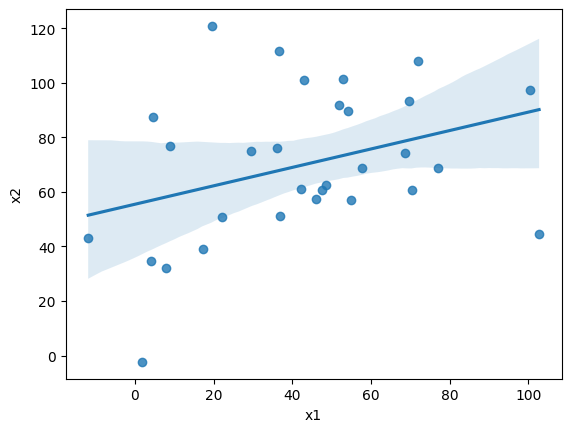

In [53]:
df = pd.DataFrame(dict(x1=x1, x2=x2))
sns.regplot(x="x1", y="x2", data=df);

In [54]:
x2_correlated = x1 + 1.5 * np.std(x1) * np.random.randn(x1.size)

r, pv = stats.pearsonr(x1, x2_correlated)
r, pv

(np.float64(0.4132334074789645), np.float64(0.0232246084674189))

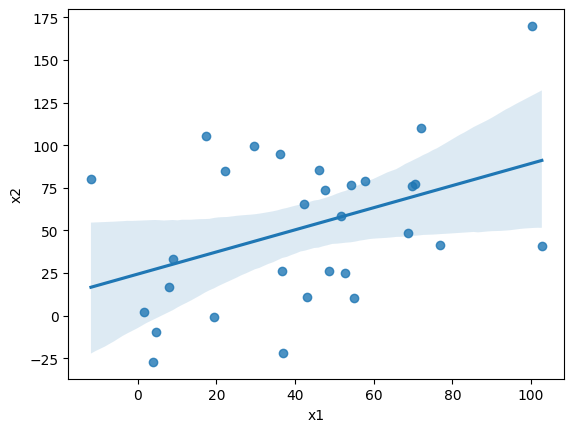

In [55]:
df = pd.DataFrame(dict(x1=x1, x2=x2_correlated))
sns.regplot(x="x1", y="x2", data=df);

Pearson $r$ assumes the observations are drawn from normal distributions.

If the data are not normally distributed, Spearman $r$ ([spearmanr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html)) is an interesting alternative, although Pearson $r$ works well enough in most cases:

In [56]:
rng = np.random.default_rng()
x1 = rng.integers(10, size=30)
x2 = x1 + rng.integers(10, size=x1.size)

# plus a few noisy observations
x1 = np.r_[x1, 9, 12]
x2 = np.r_[x2, 1, 2]

pearson_r, pearson_pv = stats.pearsonr(x1, x2)
spearman_r, spearman_pv = stats.spearmanr(x1, x2)

pearson_pv, spearman_pv

(np.float64(0.1722067016006155), np.float64(0.05172622999921983))

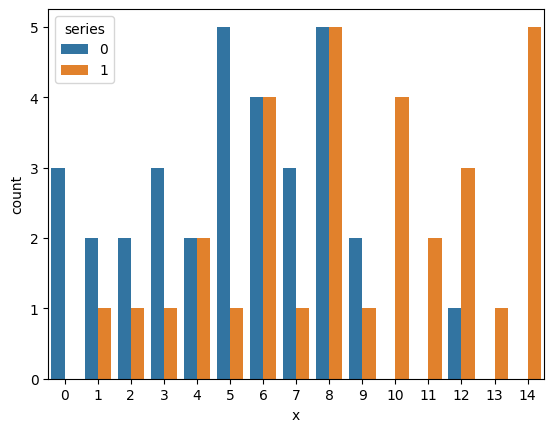

In [57]:
df = pd.DataFrame(dict(x=np.r_[x1, x2], series=np.r_[np.zeros_like(x1), np.ones_like(x2)]))
sns.countplot(x="x", data=df, hue="series");

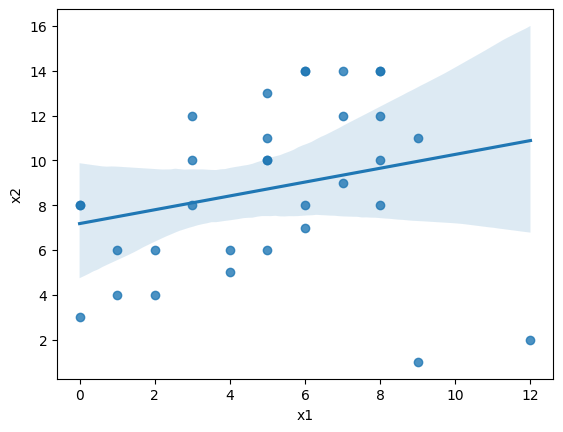

In [58]:
df = pd.DataFrame(dict(x1=x1, x2=x2))
sns.regplot(x="x1", y="x2", data=df);

What could possibly go wrong?

<table style="text-align: center;"><tr><td><img alt="Pearson vs Spearman" src="../images/Pearson_vs_Spearman.svg" width="1200px" /></td></tr>
<tr><td><a href="http://geoinfo.amu.edu.pl/qg/archives/2011/QG302_087-093.pdf">from Hauke &amp; Kossowski 2011</a></td></tr></table>

Because Pearson coefficient relies on squared differences, it is very sensitive to outliers.
On the other side, Spearman coefficient is based on ranks and may catch less intuitive patterns.

### Linear regression

As previously said, the correlation is not directly related to the regression lines we constantly plot to illustrate the relationship a correlation coefficent is supposed to quantify.

The linear regression also offers an approach for quantifying an association between two quantitative variables.

In [59]:
slope, intercept, R, pvalue, slope_std_err = stats.linregress(x1, x2)
intercept, slope, pvalue

(np.float64(7.175887788044084),
 np.float64(0.309028164310364),
 np.float64(0.1722067016006155))

The $p$-value returned by [linregress](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html) is related to $H_0$: the slope is $0$.

If there is no slope, there is no association between the variables.

A linear regression is also a model that can predict the value of one variable from the value of the other variable:

In [60]:
x1_observed = 5
x2_predicted = intercept + slope * x1_observed
x2_predicted

np.float64(8.721028609595903)

In [61]:
x2_observed = 12
x1_predicted = (x2_observed - intercept) / slope
x1_predicted

np.float64(15.610590778097983)

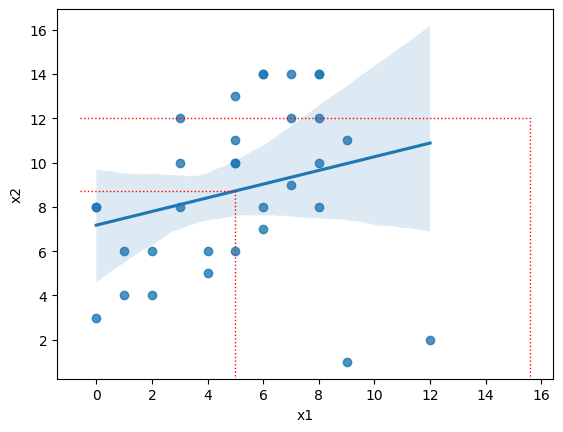

In [62]:
ax = sns.regplot(x=x1, y=x2)
x1_min, _ = ax.get_xlim()
x2_min, x2_max = ax.get_ylim()
ax.plot([x1_min, x1_observed, x1_observed], [x2_predicted, x2_predicted, x2_min], 'r:', linewidth=1)
ax.plot([x1_min, x1_predicted, x1_predicted], [x2_observed, x2_observed, x2_min], 'r:', linewidth=1)
ax.set_ylim([x2_min, x2_max])
ax.set_xlabel('x1')
ax.set_ylabel('x2');

Prior to collecting data, in the presence of preliminary data to roughly predict the expected effect size, one can estimate the sample size necessary for a test to detect such an effect.

This is done in a *power analysis*. Reminder: the power of a test is the probability of detecting an effect (rejecting $H_0$) when $H_0$ is false.

`statsmodels` features utilities for such analyses, for most of the tests previously mentioned.

* one-sample $t$-test: `TTestPower`
* $t$-test for independent samples: `TTestIndPower`
* $t$-test for dependent samples: `TTestPower`
* one-way ANOVA: `FTestAnovaPower`
* (one-sample) goodnes-of-fit $\chi^2$ test: `GofChisquarePower`

All classes, once initialized, feature a `plot_power` helper method for quickly inspecting the relationship between various parameters that are key in the design of a test:

In [63]:
nobservations = np.arange(5, 30+1, 5)
power.TTestIndPower().plot_power(nobs=nobservations, effect_size=[0.3, 0.5, 0.8, 1.2])
plt.xticks(nobservations)
plt.axhline(0.8, color='r', linestyle=':', linewidth=1)
plt.xlim(nobservations[0], nobservations[-1]);

NameError: name 'power' is not defined